In [1]:
import json
import string
import requests
from requests.exceptions import Timeout
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from datetime import datetime
from scipy.stats import linregress
import csv 
import io
from api_keys import g_key
import gmaps


In [2]:
##### read data
fatality = pd.read_csv('data/accident.csv')
injury_property_damage = pd.read_csv('data/injury_and_property_damage_only.csv')
vehicle_miles = pd.read_csv('data/vehicle_miles.csv')
injury_property_damage.head(10)

c:\Users\datqu\anaconda3\envs\bootcamp\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (28,30,32,58,64,66,86,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,caseyear,injury_only,property_damage_only
0,2010,1542104,3847045
1,2011,1529968,3777994
2,2012,1634180,3949858
3,2013,1591016,4065673
4,2014,1647726,4386502
5,2015,1715394,4548203
6,2016,2116308,4670073
7,2017,1888525,4529513
8,2018,1893704,4807058
9,2019,1916344,4806253


In [3]:
fatality.head()

,caseyear,state,st_case,statename,ve_total,ve_forms,pvh_invl,peds,pernotmvit,permvit,...,hosp_mn,hosp_mnname,cf1,cf1name,cf2,cf2name,cf3,cf3name,fatals,drunk_dr
0,2010,1,10001,Alabama,1,1,NaN,0,NaN,NaN,...,99,Unknown EMS Hospital Arrival Time,0.0,None,0.0,None,0.0,None,1,1
1,2010,1,10002,Alabama,1,1,NaN,0,NaN,NaN,...,99,Unknown EMS Hospital Arrival Time,0.0,None,0.0,None,0.0,None,1,0
2,2010,1,10003,Alabama,3,3,NaN,0,NaN,NaN,...,99,Unknown EMS Hospital Arrival Time,0.0,None,0.0,None,0.0,None,1,0
3,2010,1,10004,Alabama,2,2,NaN,0,NaN,NaN,...,88,Not Applicable (Not Transported),0.0,None,0.0,None,0.0,None,1,0
4,2010,1,10005,Alabama,2,2,NaN,0,NaN,NaN,...,88,Not Applicable (Not Transported),0.0,None,0.0,None,0.0,None,1,0


In [4]:
vehicle_miles.head(15)

,caseyear,vehicle_miles_milions,mode
0,2010,5975.78,Air
1,2011,6004.58,Air
2,2012,5956.17,Air
3,2013,5964.98,Air
4,2014,5947.35,Air
5,2015,6045.82,Air
6,2016,6227.35,Air
7,2017,6337.80,Air
8,2018,6609.01,Air
9,2019,6815.00,Air


In [5]:
# number of fatal_only crashes
fatal_case_by_year = fatality.groupby(['caseyear']).count()['fatals'].reset_index()
fatal_case_by_year.rename(columns={'fatals':'fatals_case_only'},inplace=True)
# number of death
death_by_year = fatality.groupby('caseyear').sum()['fatals'].reset_index()
# create summary table: merge data and calculate
summary_crash_case = fatal_case_by_year.merge(injury_property_damage,on='caseyear')
summary_crash_case = summary_crash_case.merge(death_by_year,on='caseyear')
summary_crash_case['total_crash'] = summary_crash_case.fatals_case_only + summary_crash_case.injury_only + summary_crash_case.property_damage_only
summary_crash_case = summary_crash_case.merge(vehicle_miles.loc[vehicle_miles['mode'] == 'Car',['caseyear','vehicle_miles_milions']],on='caseyear')
summary_crash_case['fatality_per_thousand_crash'] = summary_crash_case.fatals / summary_crash_case.total_crash * 1000
summary_crash_case['fatality_per_vmt'] = summary_crash_case.fatals / summary_crash_case.vehicle_miles_milions 
summary_crash_case.to_csv('summary_data/car.csv',index=False)
summary_crash_case.tail()

,caseyear,fatals_case_only,injury_only,property_damage_only,fatals,total_crash,vehicle_miles_milions,fatality_per_thousand_crash,fatality_per_vmt
6,2016,35017,2116308,4670073,38085,6821398,3174407.96,5.583166,0.011998
7,2017,34841,1888525,4529513,37763,6452879,3212347.31,5.852117,0.011756
8,2018,34214,1893704,4807058,37143,6734976,3240326.54,5.514942,0.011463
9,2019,33762,1916344,4806253,36644,6756359,3261771.66,5.423631,0.011234
10,2020,35995,1593390,3621681,39066,5251066,2903621.53,7.439632,0.013454


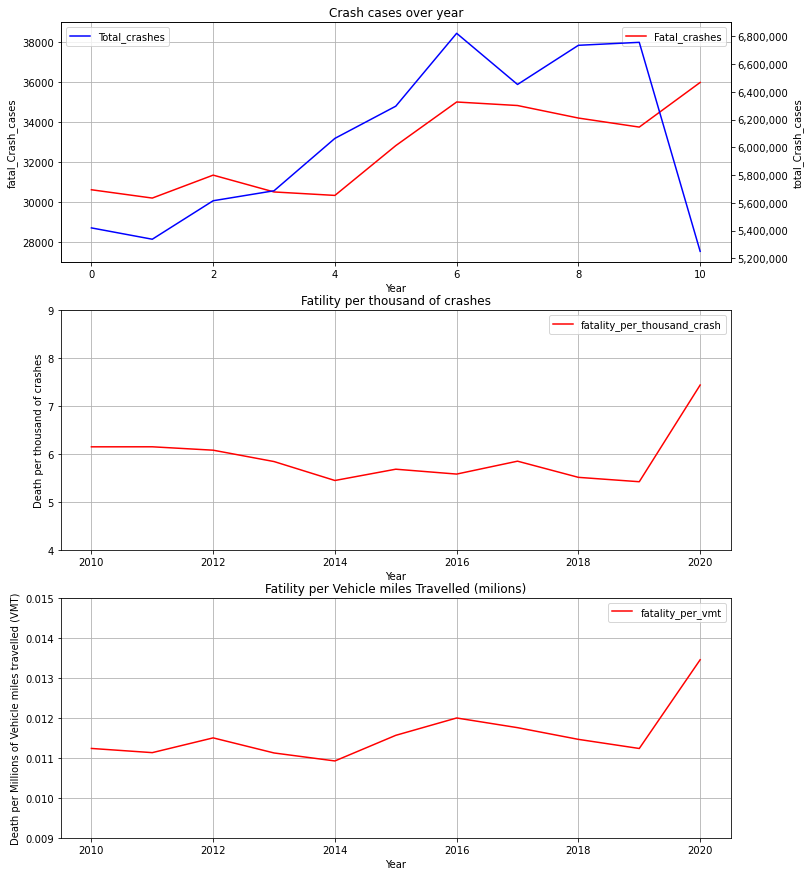

In [24]:
# plot total fatal crashes per year
fig, (p1,p2,p3) = plt.subplots(3,figsize=(12, 15))
summary_crash_case.fatals_case_only.plot(ax=p1,color='r',title='Crash cases over year')
summary_crash_case.total_crash.plot(secondary_y=True,ax=p1,color='b')
#p1.title('Crash cases over year')
p1.legend(['Fatal_crashes'],loc='upper right')
p1.right_ax.legend(['Total_crashes'])
p1.set_ylim(27000,39000)
p1.set_xlabel("Year")
p1.set_ylabel('fatal_Crash_cases')
p1.right_ax.set_ylabel('total_Crash_cases')
p1.right_ax.ticklabel_format(style='plain')
p1.right_ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p1.grid()

#plot total death per thousand of crashes
summary_crash_case.plot.line(x='caseyear',y='fatality_per_thousand_crash',ax=p2,title='Fatility per thousand of crashes',color='r')
p2.set_ylim(4,9)
p2.set_xlabel("Year")
p2.set_ylabel('Death per thousand of crashes')
p2.grid()
#plot total death per Vehicle miles travelled
summary_crash_case.plot.line(x='caseyear',y='fatality_per_vmt',ax=p3,title='Fatility per Vehicle miles Travelled (milions)',color='r')
p3.set_ylim(0.009,0.015)
p3.set_xlabel("Year")
p3.set_ylabel('Death per Millions of Vehicle miles travelled (VMT)')
p3.grid()


In [7]:
# create death per state dataframe
death_by_state = fatality.groupby(['caseyear','statename']).sum()['fatals'].reset_index()
#### top 5 states with highest death
summary_crash_top_state = death_by_state.sort_values('fatals',ascending=False).groupby('caseyear').head(5)
summary_crash_top_state = summary_crash_top_state.sort_values(['caseyear','fatals'],ascending=[True,False])
summary_crash_top_state = summary_crash_top_state.pivot(index='caseyear', columns='statename', values='fatals')
summary_crash_top_state=summary_crash_top_state [['Texas','California','Florida','Pennsylvania','North Carolina','Georgia']]
summary_crash_top_state

statename,Texas,California,Florida,Pennsylvania,North Carolina,Georgia
caseyear,,,,,,
2010,3023.0,2720.0,2444.0,1324.0,1320.0,NaN
2011,3054.0,2816.0,2400.0,1286.0,1230.0,NaN
2012,3408.0,2966.0,2431.0,1310.0,1299.0,NaN
2013,3389.0,3107.0,2403.0,1210.0,1290.0,NaN
2014,3536.0,3102.0,2494.0,1195.0,1284.0,NaN
2015,3582.0,3387.0,2938.0,NaN,1379.0,1432.0
2016,3797.0,3837.0,3176.0,NaN,1450.0,1556.0
2017,3732.0,3884.0,3116.0,NaN,1412.0,1540.0
2018,3648.0,3798.0,3135.0,NaN,1436.0,1505.0


<AxesSubplot:xlabel='caseyear'>

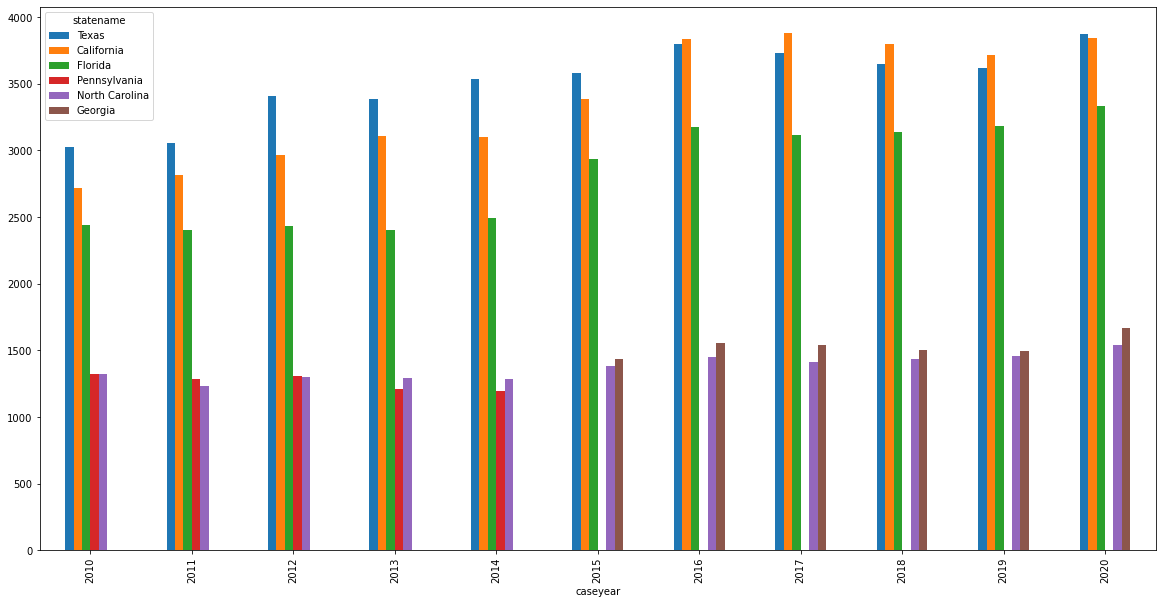

In [8]:
#plot top 5 states with highest death per year
fig, p = plt.subplots(figsize = (20,10))
summary_crash_top_state.plot(kind='bar', ax=p)

In [9]:
#create death location dataframe
death_location = fatality[['caseyear','statename','latitude','longitud','fatals']]
death_location = death_location.loc[(death_location.latitude>=-90)&(death_location.latitude<=90)&(death_location.longitud>=-180)&(death_location.longitud<=180),:]
death_location.sort_values('latitude',ascending=False)

,caseyear,statename,latitude,longitud,fatals
256664,2018,Alaska,69.733347,-148.695758,1
123493,2014,Alaska,68.433764,-149.366761,1
186881,2016,Alaska,68.344956,-166.777369,1
221839,2017,Alaska,68.146761,-151.730875,1
123468,2014,Alaska,66.970956,-160.434492,1
...,...,...,...,...,...
351256,2020,Puerto Rico,17.974564,-66.058481,1
351250,2020,Puerto Rico,17.973292,-66.924519,1
351218,2020,Puerto Rico,17.970453,-66.271653,1
351171,2020,Puerto Rico,17.968258,-66.252503,1


In [10]:
gmaps.configure(api_key=g_key)
crash_loc_df= death_location[['latitude', 'longitud']]
weight = death_location['fatals']
fig = gmaps.figure(zoom_level=4,
                   center=(38.58,-96.46),
                   layout={'width': '1000px',
                    'height': '600px',
                    'padding': '3px',
                    'border': '1px solid black'})
heatmap_layer = gmaps.heatmap_layer(crash_loc_df,weights=weight,max_intensity=5000,point_radius=28,dissipating=True)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='3px', width='1000px'))

In [90]:
#analyse fatality per causes
cause_df = fatality[['caseyear','statename','lgt_condname','weathername','drunk_dr','fatals','day_weekname','day_week']]
cause_df


,caseyear,statename,lgt_condname,weathername,drunk_dr,fatals,day_weekname,day_week
0,2010,Alabama,Dark - Lighted,Clear,1,1,Friday,6
1,2010,Alabama,Dark - Lighted,Clear,0,1,Monday,2
2,2010,Alabama,Daylight,Clear,0,1,Thursday,5
3,2010,Alabama,Dark - Lighted,Rain,0,1,Thursday,5
4,2010,Alabama,Dawn,Clear,0,1,Monday,2
...,...,...,...,...,...,...,...,...
359712,2020,Wyoming,Dark - Not Lighted,Snow,0,1,Saturday,7
359713,2020,Wyoming,Dark - Not Lighted,Clear,0,2,Friday,6
359714,2020,Wyoming,Dark - Not Lighted,Snow,0,1,Friday,6
359715,2020,Wyoming,Dark - Not Lighted,Clear,0,1,Tuesday,3


c:\Users\datqu\anaconda3\envs\bootcamp\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
c:\Users\datqu\anaconda3\envs\bootcamp\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(0.0, 300000.0)

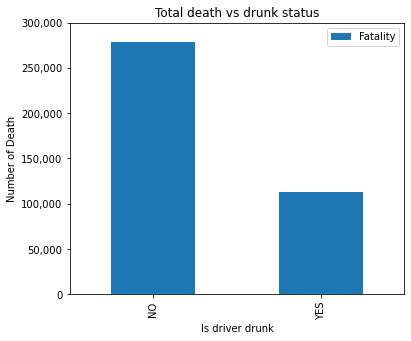

In [79]:
#fatality vs drunk driver
cause_df.loc[cause_df['drunk_dr']>=1,'drunk_driver']='YES'
cause_df.loc[cause_df['drunk_dr']==0,'drunk_driver']='NO'
drunk_drive = cause_df.groupby('drunk_driver').sum()['fatals'].reset_index()
drunk_drive.set_index('drunk_driver',inplace=True)
p = drunk_drive.plot.bar(figsize =(6,5),title='Total death vs drunk status')
p.set_xlabel ('Is driver drunk')
p.set_ylabel ('Number of Death')
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p.legend(['Fatality'])
p.set_ylim(0,300000)

(0.0, 80000.0)

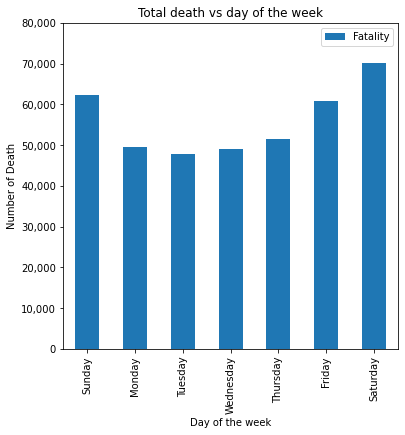

In [88]:
#fatility vs day in week
day_map = cause_df[['day_week','day_weekname']].drop_duplicates()
day_of_week_df = cause_df.sort_values('day_week',ascending=True)
day_of_week_df=day_of_week_df.groupby('day_weekname').sum()['fatals'].reset_index()
day_of_week_df=day_of_week_df.merge(day_map,on='day_weekname').sort_values('day_week',ascending=True)
del day_of_week_df['day_week']
day_of_week_df.set_index('day_weekname',inplace=True)
p = day_of_week_df.plot.bar(figsize =(6,6),title='Total death vs day of the week')
p.set_xlabel ('Day of the week')
p.set_ylabel ('Number of Death')
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p.legend(['Fatality'])
p.set_ylim(0,80000)

(0.0, 200000.0)

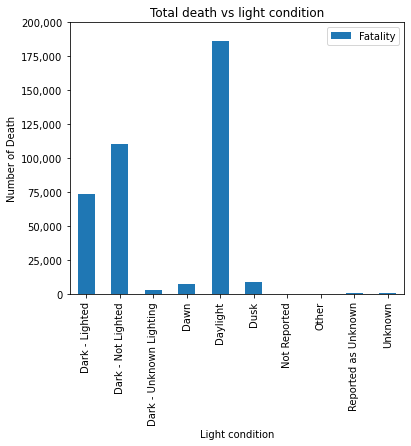

In [95]:
#fatility vs light
light_condition_crash_df = cause_df.groupby('lgt_condname').sum()['fatals'].reset_index()
light_condition_crash_df.set_index('lgt_condname',inplace=True)
p = light_condition_crash_df.plot.bar(figsize =(6,5),title='Total death vs light condition')
p.set_xlabel ('Light condition')
p.set_ylabel ('Number of Death')
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p.legend(['Fatality'])
p.set_ylim(0,200000)

(0.0, 300000.0)

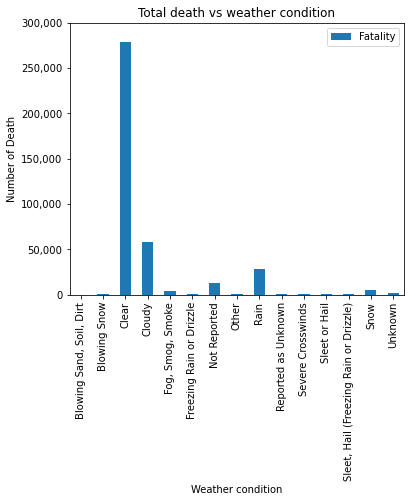

In [92]:
#fatility vs weather
weather_crash_df = cause_df.groupby('weathername').sum()['fatals'].reset_index()
weather_crash_df.set_index('weathername',inplace=True)
p = weather_crash_df.plot.bar(figsize =(6,5),title='Total death vs weather condition')
p.set_xlabel ('Weather condition')
p.set_ylabel ('Number of Death')
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p.legend(['Fatality'])
p.set_ylim(0,300000)